In [9]:
import os
import zipfile
import random
import tensorflow as tf
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<img src='/images/inception_a.jpg'>
<img src='/images/inception_b.jpg'>
<img src='/images/inception_c.jpg'>
<img src='/images/AuxiliaryClassifier.jpg'>

<img src='/images/inceptionv3.jpg'>

## Loading and Preparing a Pre-trained InceptionV3 Model

loads a pre-trained InceptionV3 model and prepares it for transfer learning. Here's a breakdown:

1. **Local Weights File:**
   - defines a path to a local file containing pre-trained InceptionV3 weights (`local_weights_file`).

2. **Loading the Model:**
   - The `InceptionV3` class is used to create a model instance.
   - The model is configured with:
      - `input_shape`: Set to a desired input size (here, 150x150x3 for RGB images).
      - `include_top`: Set to `False` to exclude the final classification layers.
      - `weights`: Set to `None` to prevent loading default weights from the library.

3. **Loading Pre-trained Weights:**
   - The `load_weights` method is called on the model, specifying the path to the local weights file (`local_weights_file`).
   - This loads the pre-trained weights from the file into the model.

4. **Freezing Pre-trained Layers:**
   - We iterates through all layers (`pre_trained_model.layers`) and sets their `trainable` attribute to `False`.
   - This freezes the pre-trained weights in these layers, preventing them from being updated during training.

5. **Extracting Last Layer Output:**
   - The `get_layer` method is used to retrieve the layer named 'mixed7' (the last convolutional layer before the classification head).


In [2]:
local_weights_file = 'Model\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## `top_layers` Function

The `top_layers` function builds a new "head" for transfer learning.

1. **Flatten:** It transforms the pre-trained model's output into a 1D vector using `layers.Flatten()`.
2. **Fully Connected Layer:** A dense layer with 1024 neurons and ReLU activation is added to learn from features.
3. **Output Layer:** A final layer with sigmoid activation predicts the probability of the target class (assuming binary classification).


In [4]:
def top_layers(trained_model_output):
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(trained_model_output)
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense  (1, activation='sigmoid')(x)
    return x

In [6]:
x = top_layers(last_output)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


## Data Augmentation and Generators

Sets up data generators for training and validation.

- **Train Augmentation (train_datagen):** Applies random transformations (rotations, shifts, flips) to increase training data and improve model robustness.
- **Validation (test_datagen):** Only rescales to maintain consistency with training preprocessing but avoids artificial variations.
- **Generators (flow_from_directory):** Read images in batches from directories for efficient training.

This approach prepares training data with augmentation and both sets for the model.


In [15]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory('Data/training',
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( 'Data/testing',
                                                          batch_size  = 64,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 25000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


length of our dataset images(Train and Test): 25000


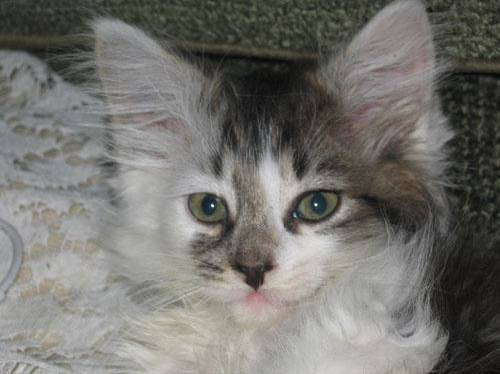

In [45]:
# Getting a random picture from our dataset
image_path = Path('/training')
images_path_list = list(image_path.glob('*/*.jpg'))
print(f'length of our dataset images(Train and Test): {len(images_path_list)}')
random_img = random.choice(images_path_list)
img = Image.open(random_img)
img

Defines a custom callback (`myCallback`) for early stopping. It checks validation accuracy after each epoch and stops training if it exceeds 93%, preventing overfitting and saving training time.


In [16]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.93):
            
            print("\nReached 93.0% accuracy")
            self.model.stop_training = True


In [17]:
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 390,
            epochs = 20,
            validation_steps = 156,
            verbose = 2,
            callbacks=[callbacks])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 390 steps, validate for 156 steps
Epoch 1/20
390/390 - 156s - loss: 0.3430 - acc: 0.8437 - val_loss: 0.2702 - val_acc: 0.9541
Epoch 2/20
390/390 - 153s - loss: 0.2659 - acc: 0.8873 - val_loss: 0.3161 - val_acc: 0.9568
Epoch 3/20
390/390 - 152s - loss: 0.2485 - acc: 0.8960 - val_loss: 0.3368 - val_acc: 0.9632
Epoch 4/20
390/390 - 152s - loss: 0.2391 - acc: 0.9005 - val_loss: 0.3824 - val_acc: 0.9614
Epoch 5/20
390/390 - 153s - loss: 0.2324 - acc: 0.9050 - val_loss: 0.3522 - val_acc: 0.9641
Epoch 6/20
390/390 - 153s - loss: 0.2240 - acc: 0.9096 - val_loss: 0.4281 - val_acc: 0.9612
Epoch 7/20
390/390 - 152s - loss: 0.2189 - acc: 0.9125 - val_loss: 0.4683 - val_acc: 0.9585
Epoch 8/20
390/390 - 153s - loss: 0.2161 - acc: 0.9154 - val_loss: 0.4286 - val_acc: 0.9619
Epoch 9/20
390/390 - 152s - loss: 0.2122 - acc: 0.9144 - val_loss: 0.5038 - val_acc: 0.9564
Epoch 10/20
390/390 - 153s - loss: 0.2103 - acc: 0.9198 - val_loss: 0.5360 - v

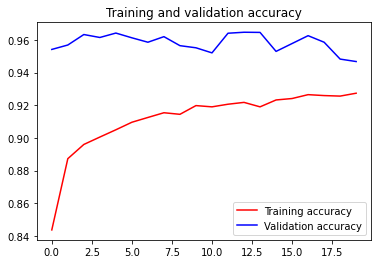

<Figure size 432x288 with 0 Axes>

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()